In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy import stats

import acquire as ac
import prepare as pr

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = ac.get_telco_data()
encoder, train, validate, test = pr.prep_telco(df)
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (4218, 21)
validate shape = (1407, 20)
    test shape = (1407, 20)


In [3]:
train.head()

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,0,Multiple lines,Partner,TV and movies,Security and backup,6.0
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,0,Single line,Single,Movies,Backup,2.0
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,0,Single line,Partner and dependents,No internet service,No internet service,0.0
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,0,Single line,Partner,None,Security and backup,4.0
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,0,Single line,Partner,TV,Security,1.0


---
# Explore

## 1. If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

$H_0$: The churn rate for customers whose tenure is less than or equal to one year is the same as all other customers

$H_a$: The churn rate for customers whose tenure is less than or equal to one year is different than all other customers

In [4]:
alpha = .001

x = train[train.tenure_years <= 1].churn
mu = train.churn.mean()

tstat, p = stats.ttest_1samp(x, mu)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

t statistic = 14.767252115963558
    p-value = 2.5543291149045378e-46

Reject the null hypothesis


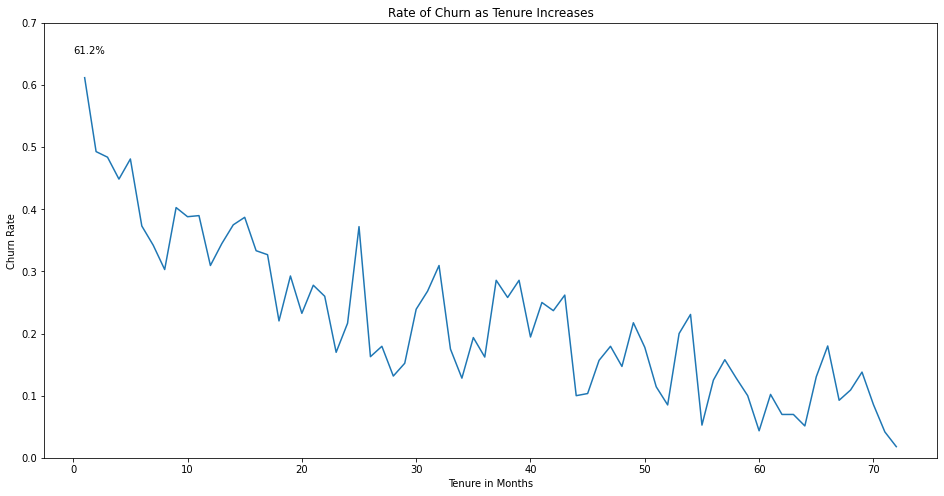

In [5]:
# plotting churn rate by tenure months
monthly = pd.DataFrame({
    "tenure": np.sort(train.tenure.unique()),
})

monthly["churn_rate"] = [((train.churn == 1) & (train.tenure == n)).sum() / (train.tenure == n).sum() for n in monthly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(monthly.tenure, monthly.churn_rate)
plt.text(0, .65, f"{train[train.tenure == 1].churn.mean():.1%}")
plt.xlabel("Tenure in Months")
plt.ylabel("Churn Rate")
plt.ylim(0, .7)
plt.show()

> **Clearly, the rate of churn declines as the customer's tenure with the company increases.**

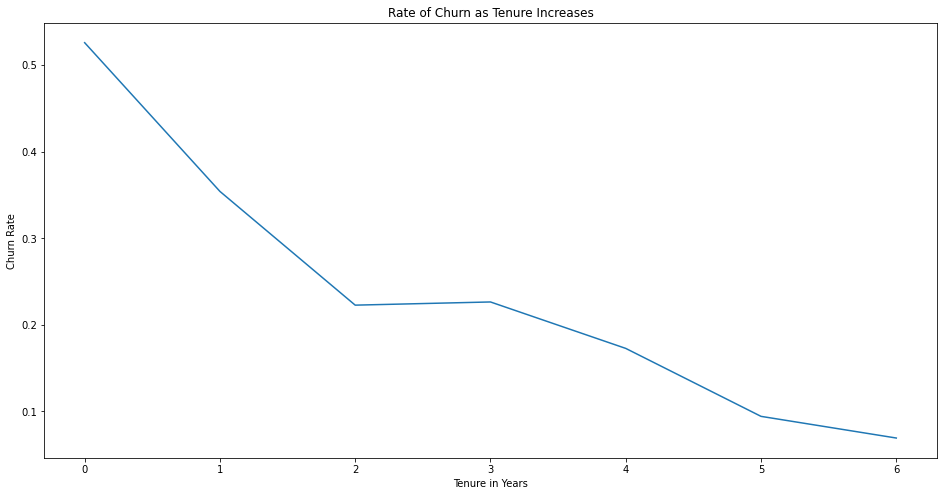

In [6]:
# plotting churn rate by tenure years
yearly = pd.DataFrame({
    "tenure": np.sort(train.tenure_years.unique()),
})

yearly["churn_rate"] = [((train.churn == 1) & (train.tenure_years == n)).sum() / (train.tenure_years == n).sum() for n in yearly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(yearly.tenure, yearly.churn_rate)
plt.xlabel("Tenure in Years")
plt.ylabel("Churn Rate")
plt.show()

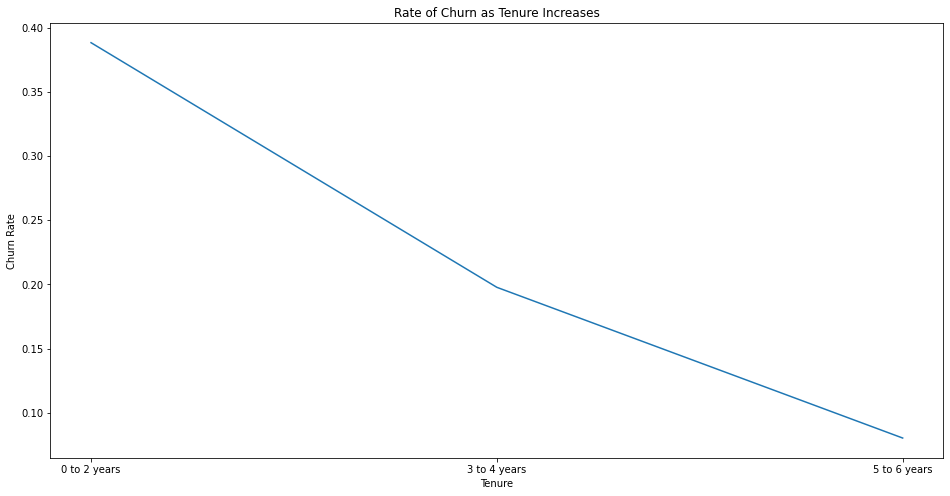

In [7]:
# plotting churn rate by tenure years binned
train["tenure_years_binned"] = pd.cut(train.tenure_years, bins=3, labels=["0 to 2 years", "3 to 4 years", "5 to 6 years"])

binned = pd.DataFrame({
    "tenure": np.sort(train.tenure_years_binned.unique()),
})

binned["churn_rate"] = [((train.churn == 1) & (train.tenure_years_binned == b)).sum() / (train.tenure_years_binned == b).sum() for b in binned.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(binned.tenure, binned.churn_rate)
plt.xlabel("Tenure")
plt.ylabel("Churn Rate")
plt.show()

---
## 2. Are there features that indicate a higher propensity to churn? 

#### Churn Rate by Internet Service Type

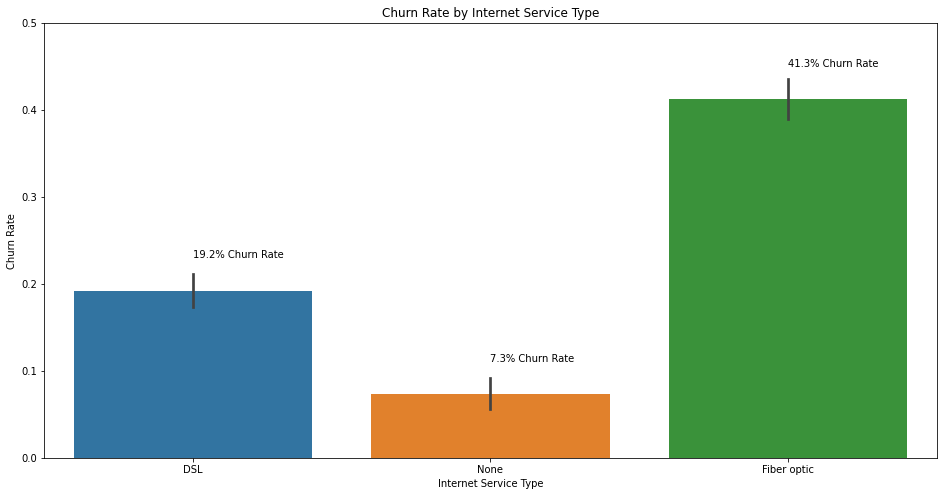

In [8]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Internet Service Type")
sns.barplot(train.internet_service_type, train.churn)
plt.text(0, .23, f"{train[train.internet_service_type == 'DSL'].churn.mean():.1%} Churn Rate")
plt.text(1, .11, f"{train[train.internet_service_type == 'None'].churn.mean():.1%} Churn Rate")
plt.text(2, .45, f"{train[train.internet_service_type == 'Fiber optic'].churn.mean():.1%} Churn Rate")
plt.xlabel("Internet Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .5)
plt.show()

> Fiber optic internet service type seems to be a driver of churn. 41.3% of the customers with fiber optic internet service are likely to churn.

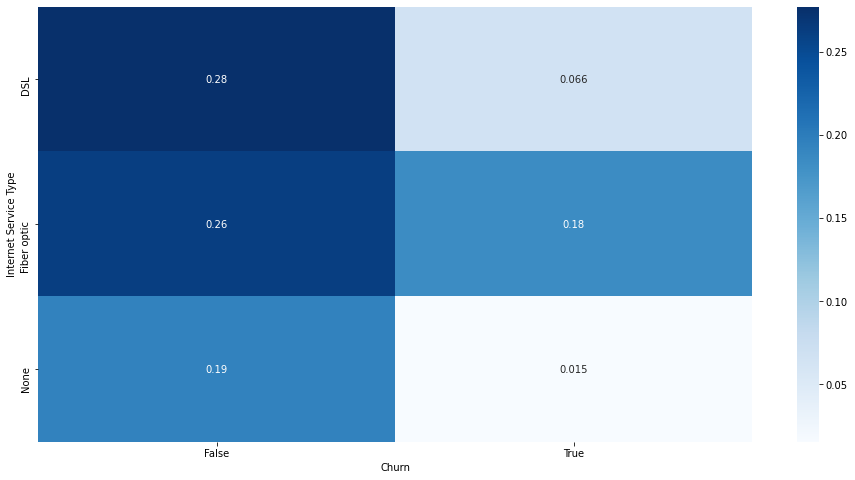

In [9]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.internet_service_type, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Internet Service Type")
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who are using fiber optic internet service and have churned make up 18% of all customers.**

---
#### Churn Rate by Phone Service Type

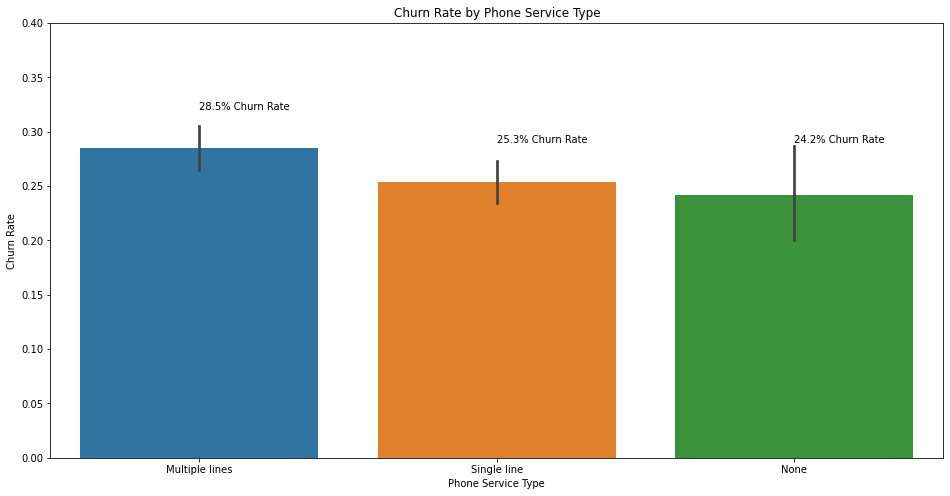

In [10]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Phone Service Type")
sns.barplot(train.phone_service_type, train.churn)
plt.text(0, .32, f"{train[train.phone_service_type == 'Multiple lines'].churn.mean():.1%} Churn Rate")
plt.text(1, .29, f"{train[train.phone_service_type == 'Single line'].churn.mean():.1%} Churn Rate")
plt.text(2, .29, f"{train[train.phone_service_type == 'None'].churn.mean():.1%} Churn Rate")
plt.xlabel("Phone Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .4)
plt.show()

> **There does not seem to be a significant difference in the churn rate when considering the phone service type**

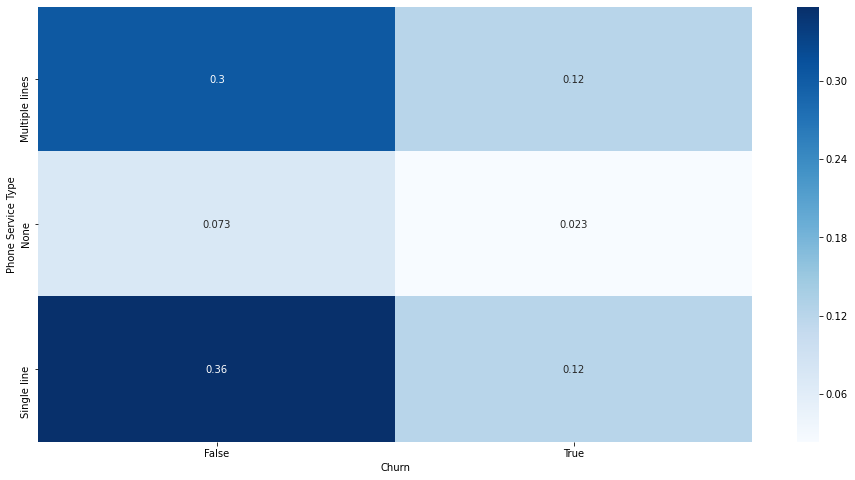

In [11]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.phone_service_type, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Phone Service Type")
plt.xticks((.5, 1.5), (False, True))
plt.show()

---
#### Churn Rate by Online Protection

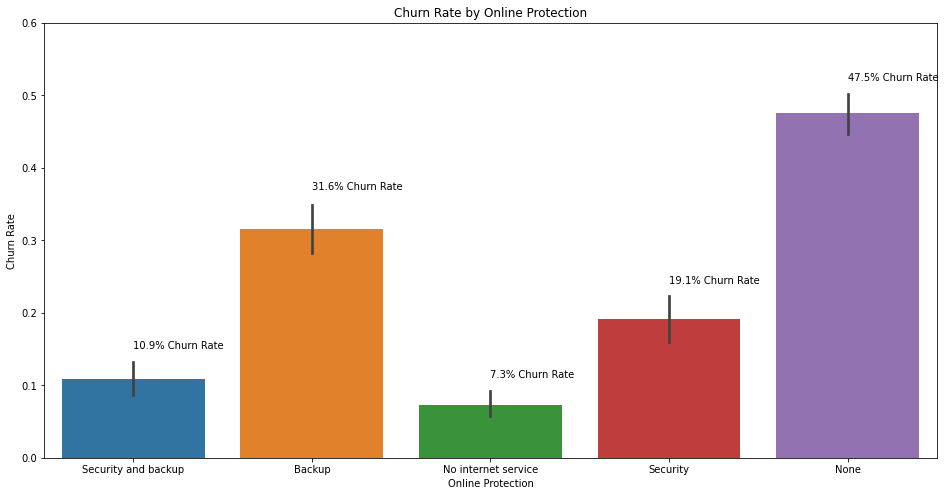

In [12]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Online Protection")
sns.barplot(train.online_protection, train.churn)
plt.text(0, .15, f"{train[train.online_protection == 'Security and backup'].churn.mean():.1%} Churn Rate")
plt.text(1, .37, f"{train[train.online_protection == 'Backup'].churn.mean():.1%} Churn Rate")
plt.text(2, .11, f"{train[train.online_protection == 'No internet service'].churn.mean():.1%} Churn Rate")
plt.text(3, .24, f"{train[train.online_protection == 'Security'].churn.mean():.1%} Churn Rate")
plt.text(4, .52, f"{train[train.online_protection == 'None'].churn.mean():.1%} Churn Rate")
plt.xlabel("Online Protection")
plt.ylabel("Churn Rate")
plt.ylim(0, .6)
plt.show()

> **47.5% of the customers that have no online protection churn.**

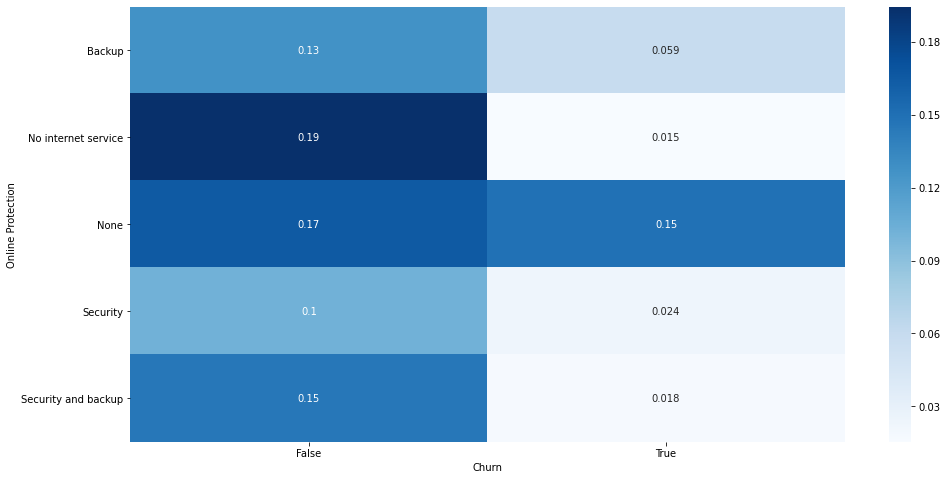

In [13]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.online_protection, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Online Protection")
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who have no online protection plan and who have churned make up 15% of all customers.**

---
#### Churn Rate by Senior Citizen Status

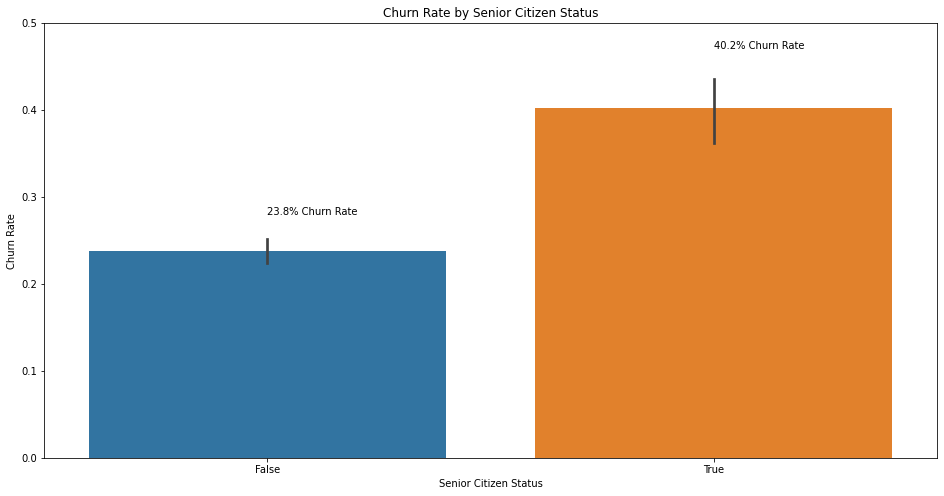

In [14]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Senior Citizen Status")
sns.barplot(train.senior_citizen, train.churn)
plt.text(0, .28, f"{train[train.senior_citizen == 0].churn.mean():.1%} Churn Rate")
plt.text(1, .47, f"{train[train.senior_citizen == 1].churn.mean():.1%} Churn Rate")
plt.xlabel("Senior Citizen Status")
plt.ylabel("Churn Rate")
plt.xticks((0, 1), (False, True))
plt.ylim(0, .5)
plt.show()

> **40.2% of all senior citizens churn**

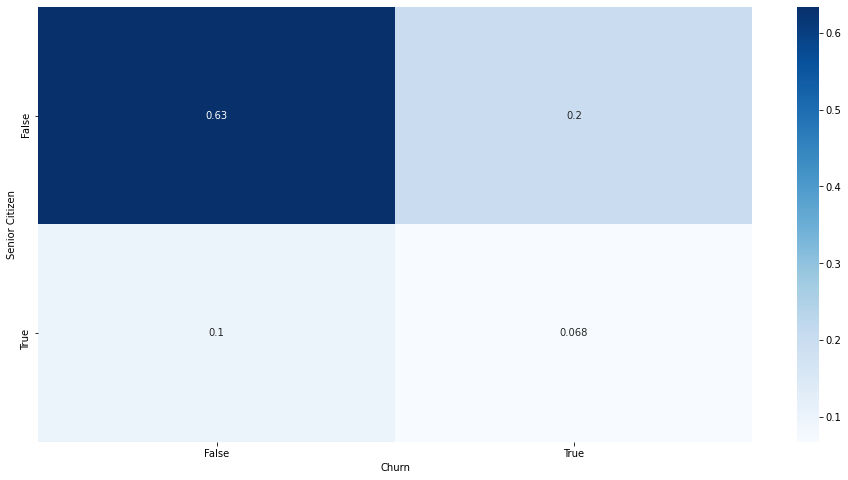

In [15]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.senior_citizen, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Senior Citizen")
plt.yticks((.5, 1.5), (False, True))
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who are not senior citizens and who have churned make up 20% of all customers.**

---
## 3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

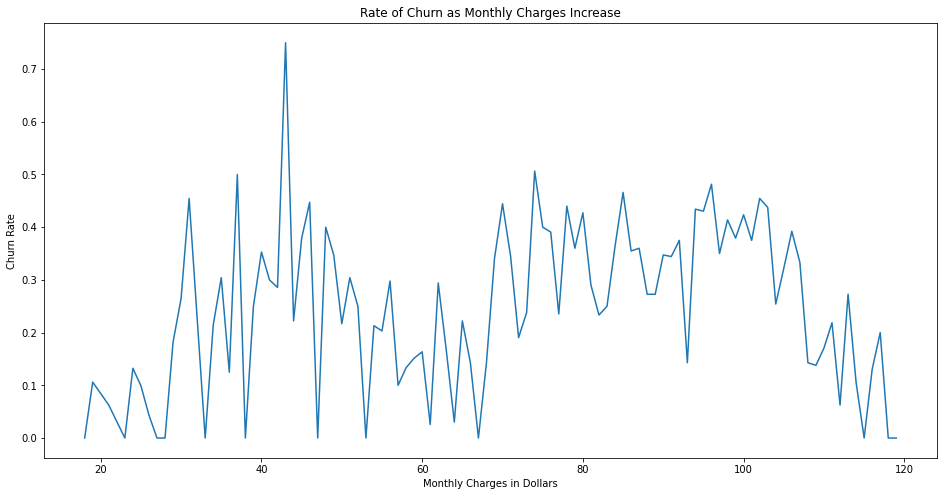

In [16]:
# plotting churn rate by monthly_charges
monthly_charges = pd.DataFrame({
    "charges": np.sort(train.monthly_charges.round().unique()),
})

monthly_charges["churn_rate"] = [((train.churn == 1) & (train.monthly_charges.round() == n)).sum() / (train.monthly_charges.round() == n).sum() for n in monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase")
plt.plot(monthly_charges.charges, monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

In [17]:
# # plotting churn rate by monthly_charges
# dsl_monthly_charges = pd.DataFrame({
#     "charges": np.sort(train[train.internet_service_type == "DSL"].monthly_charges.round().unique()),
# })

# monthly_charges["churn_rate"] = [((train.churn == 1) & (train.monthly_charges.round() == n)).sum() / (train.monthly_charges.round() == n).sum() for n in dsl_monthly_charges.charges]

# plt.figure(figsize=(16, 8))

# plt.title("Rate of Churn as Monthly Charges Increase")
# plt.plot(dsl_monthly_charges.charges, dsl_monthly_charges.churn_rate)
# plt.xlabel("Monthly Charges in Dollars")
# plt.ylabel("Churn Rate")
# plt.show()

---
## 4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$H_0$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is the same

$H_a$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is different

In [18]:
alpha = .001

month_to_month = train[(train.contract_type == "Month-to-month") & (train.tenure > 12)].churn
annual = train[(train.contract_type == "One year") & (train.tenure > 12)].churn

tstat, p = stats.ttest_ind(month_to_month, annual)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")
print()
print(f"The churn rate for month-to-month customers after the 12th month is {month_to_month.mean():.1%}")
print(f"The churn rate for 1-year contract customers after the 12th month is {annual.mean():.1%}")
print()
print("""It can be stated with 99.9% certainty that month-to-month customers after the 12th month churn at almost
3x the rate of 1-year contract customers after the 12th month.

Takeaway: If we are trying to reduce churn, we should be more aggressive in contract aquisition""")

t statistic = 10.939201115216212
    p-value = 4.6357843354484826e-27

Reject the null hypothesis

The churn rate for month-to-month customers after the 12th month is 33.0%
The churn rate for 1-year contract customers after the 12th month is 11.8%

It can be stated with 99.9% certainty that month-to-month customers after the 12th month churn at almost
3x the rate of 1-year contract customers after the 12th month.

Takeaway: If we are trying to reduce churn, we should be more aggressive in contract aquisition


---
# Model

In [19]:
scaler, train, validate, test = pr.min_max_scaler(train, validate, test)
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [20]:
train.head()

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years,tenure_years_binned
5767,6885-PKOAM,Female,0,0.985915,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),0.671642,6223.80,0,Multiple lines,Partner,TV and movies,Security and backup,6.0,5 to 6 years
601,4923-ADWXJ,Female,0,0.338028,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),0.473134,1679.65,0,Single line,Single,Movies,Backup,2.0,0 to 2 years
6469,1099-GODLO,Female,0,0.000000,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,0.020896,20.35,0,Single line,Partner and dependents,No internet service,No internet service,0.0,0 to 2 years
5729,6374-AFWOX,Male,0,0.633803,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,0.471642,3047.15,0,Single line,Partner,None,Security and backup,4.0,3 to 4 years
1163,9489-UTFKA,Male,1,0.098592,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),0.424378,551.95,0,Single line,Partner,TV,Security,1.0,0 to 2 years


In [21]:
# identifying train features and target
X_train = train[["senior_citizen", "tenure", "monthly_charges"]]
y_train = train[["churn"]]

# identifying validate features and target
X_validate = validate[["senior_citizen", "tenure", "monthly_charges"]]
y_validate = validate[["churn"]]

# identifying test features and target
X_test = test[["senior_citizen", "tenure", "monthly_charges"]]
y_test = test[["churn"]]

In [22]:
positive = 1

predictions = pd.DataFrame({
    "actual": train.churn,
    "baseline": positive
})

predictions

,actual,baseline
5767,0,1
601,0,1
6469,0,1
5729,0,1
1163,0,1
...,...,...
980,0,1
94,0,1
123,0,1
3909,0,1


In [23]:
predictions.actual.value_counts()

0    3097
1    1121
Name: actual, dtype: int64

---
## Logistic Regression

In [24]:
logit = LogisticRegression()
logit.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (logit)"] = logit.predict(X_train)

print(f"Train Accuracy: {logit.score(X_train, y_train.churn):.2%}")

Train Accuracy: 79.23%


---
## Decision Tree

In [25]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (clf2)"] = clf.predict(X_train)

print(f"Train Accuracy: {clf.score(X_train, y_train.churn):.2%}")

Train Accuracy: 78.26%


In [26]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (clf5)"] = clf.predict(X_train)

print(f"Train Accuracy: {clf.score(X_train, y_train.churn):.2%}")

Train Accuracy: 79.61%


---
## Random Forest

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (rf)"] = rf.predict(X_train)

print(f"Train Accuracy: {rf.score(X_train, y_train.churn):.2%}")

Train Accuracy: 95.80%


In [34]:
rf = RandomForestClassifier(min_samples_leaf=3, max_depth=6)
rf.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (rf3/5)"] = rf.predict(X_train)

print(f"Train Accuracy: {rf.score(X_train, y_train.churn):.2%}")

Train Accuracy: 80.23%


In [29]:
RandomForestClassifier?

---
## K Nearest Neighbors

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (knn5)"] = knn.predict(X_train)

print(f"Train Accuracy: {knn.score(X_train, y_train.churn):.2%}")

Train Accuracy: 83.40%


In [31]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (knn10)"] = knn.predict(X_train)

print(f"Train Accuracy: {knn.score(X_train, y_train.churn):.2%}")

Train Accuracy: 81.01%


In [32]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train.churn)
y_train["churn ~ senior_citizen + tenure + monthly_charges (knn20)"] = knn.predict(X_train)

print(f"Train Accuracy: {knn.score(X_train, y_train.churn):.2%}")

Train Accuracy: 80.13%
